<a href="https://colab.research.google.com/github/laurynasjs/various/blob/master/tribe_ai_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Natural Language Processing with Disaster Tweets

> In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

https://www.kaggle.com/c/nlp-getting-started/overview/description

## imports

In [107]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [108]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.text.all import *
from fastai.text import *

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !pip install --upgrade --force-reinstall --no-deps kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lauriux","key":"4710ed5da01da483630a54dd5d336365"}'}

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-15 08:36:45           5294  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2923  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            335  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1768  
imsparsh/musicnet-dataset                                   MusicNet Dataset

In [ ]:
!kaggle competitions list -s 'nlp'

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
nlp-getting-started                                2030-01-01 00:00:00  Getting Started  Knowledge       2721            True  
jigsaw-unintended-bias-in-toxicity-classification  2019-07-18 19:35:00  Featured           $65,000       3165           False  
google-quest-challenge                             2020-02-10 23:59:00  Featured           $25,000       1571           False  
gendered-pronoun-resolution                        2019-04-22 23:59:00  Research           $25,000        838           False  
word2vec-nlp-tutorial                              2015-06-30 23:59:00  Getting Started  Knowledge        577           False  
trec-covid-information-retrieval                   2020-06-03 11:00:00  Research             Kudos      

In [7]:
!mkdir nlp-getting-started

In [8]:
!kaggle competitions download 'nlp-getting-started' -p /content/nlp-getting-started/ 

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 60.7MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 53.4MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 20.3MB/s]


In [9]:
!ls nlp-getting-started/

sample_submission.csv  test.csv  train.csv


In [ ]:
# !mv "sample_submission.csv" "nlp-getting-started"

In [19]:
# !unzip nlp-getting-started/nlp-getting-started.zip -d nlp-getting-started/

Archive:  nlp-getting-started/nlp-getting-started.zip
  inflating: nlp-getting-started/sample_submission.csv  
  inflating: nlp-getting-started/test.csv  
  inflating: nlp-getting-started/train.csv  


## reading data

In [10]:
path = Path("nlp-getting-started")
Path.BASE_PATH = path
path.ls()

(#3) [Path('train.csv'),Path('test.csv'),Path('sample_submission.csv')]

In [24]:
df = pd.read_csv(path/'train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [12]:
|df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [13]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')

In [14]:
# df_train = pd.read_csv('nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
# df_test = pd.read_csv('nlp-getting-started/test.csv', dtype={'id': np.int16})

# print('Training Set Shape = {}'.format(df_train.shape))
# print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
# print('Test Set Shape = {}'.format(df_test.shape))
# print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [19]:
# text_columns = 'text'
# tweets = pd.concat([train[text_columns], test[text_columns]])

In [20]:
# dataset for fine-tuning language model which only needs the text data

df = pd.concat([train, test], axis=0)[[text_columns]]
print(df.shape)
df.head()

(10876, 1)


,text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


## EDA

In [95]:
df[df["target"]==1]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [81]:
df[df["target"]==0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Lion gig tonight. Hearing is wrecked. http://t.co/oMNBAtJEAO,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's stock - CNBC http://t.co/N6RBnHMTD4,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Kittens finally arrived! gameofkittens #explodingkittensÛ_ https://t.co/TFGrAyuDC5,0
7587,10841,NaN,NaN,Sirens everywhere!,0


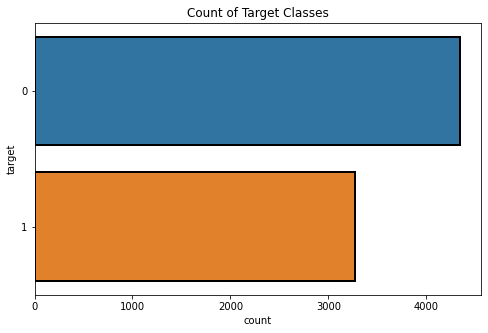

In [115]:
# Visualizing the target classes
plt.figure(figsize=(8,5))
plt.title("Count of Target Classes")
sns.countplot(y=train["target"],linewidth=2,
                   edgecolor='black')

plt.show()

In [134]:
train[train['target']==1]['text'].str.len()

0        69
1        38
2       133
3        65
4        88
       ... 
7608     83
7609    125
7610     65
7611    137
7612     94
Name: text, Length: 3271, dtype: int64

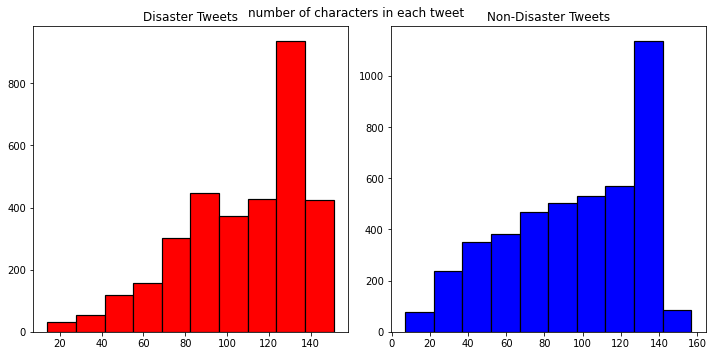

In [137]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
char_len_dis = train[train['target']==1]['text'].str.len()
ax1.hist(char_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets')

char_len_ndis = train[train['target']==0]['text'].str.len()
ax2.hist(char_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets')

plt.suptitle("number of characters in each tweet")
plt.tight_layout()
plt.show()

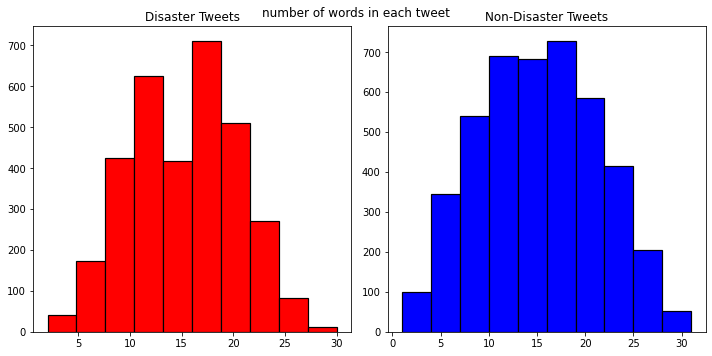

In [140]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

char_len_dis = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(char_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets')

char_len_ndis = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(char_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets')

plt.suptitle("number of words in each tweet")
plt.tight_layout()
plt.show()

## Fine-tuning the Language Model



In [59]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    # splitter=RandomSplitter(0.1) 
)

In [60]:
dls_lm = dls_lm.dataloaders(df, bs=128, seq_len=72)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [61]:
dls_lm.show_batch(max_n=3)

,text,text_
0,xxbos # xxunk # xxunk xxmaj avalanche xxmaj defense : xxmaj how xxmaj they xxmaj match vs xxmaj st . xxmaj louis xxmaj xxunk http : / / t.co / xxunk # xxunk xxbos xxunk % but if they had lower xxunk than 16 i would have gone even further xxup xxunk . xxmaj this could really fall off a cliff . xxbos xxmaj xxunk always leads to destruction xxbos xxup apc,# xxunk # xxunk xxmaj avalanche xxmaj defense : xxmaj how xxmaj they xxmaj match vs xxmaj st . xxmaj louis xxmaj xxunk http : / / t.co / xxunk # xxunk xxbos xxunk % but if they had lower xxunk than 16 i would have gone even further xxup xxunk . xxmaj this could really fall off a cliff . xxbos xxmaj xxunk always leads to destruction xxbos xxup apc xxmaj
1,/ / t.co / xxunk xxbos xxmaj but no lies though . xxmaj it 's pays to be the xxunk sometimes . xxmaj like being the first to get a car and have no curfew . # freedom # xxunk xxbos # xxmaj xxunk industry xxunk on # xxunk : # xxmaj markets : # xxmaj money xxmaj times http : / / t.co / xxunk xxbos xxmaj xxunk xxmaj xxunk xxmaj,/ t.co / xxunk xxbos xxmaj but no lies though . xxmaj it 's pays to be the xxunk sometimes . xxmaj like being the first to get a car and have no curfew . # freedom # xxunk xxbos # xxmaj xxunk industry xxunk on # xxunk : # xxmaj markets : # xxmaj money xxmaj times http : / / t.co / xxunk xxbos xxmaj xxunk xxmaj xxunk xxmaj causes
2,/ xxunk xxbos xxmaj new xxmaj giant xxmaj flames ( giant xxmaj xxunk xxmaj brown ) info / order xxunk xxunk http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj it is not always friendship when xxunk show up neither is it always xxunk that shows up when wounds show up . # xxunk xxbos xxunk 600 xxrep 3 ! xxup wow xxrep 3 !,xxunk xxbos xxmaj new xxmaj giant xxmaj flames ( giant xxmaj xxunk xxmaj brown ) info / order xxunk xxunk http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj it is not always friendship when xxunk show up neither is it always xxunk that shows up when wounds show up . # xxunk xxbos xxunk 600 xxrep 3 ! xxup wow xxrep 3 ! that


In [62]:
# Saving the dataloader for fast use in the future
torch.save(dls_lm, '/content/drive/MyDrive/disaster_tweets_dls_lm.pkl')

In [63]:
# To load the Dataloaders in the future
dls_lm_test = torch.load('/content/drive/MyDrive/disaster_tweets_dls_lm.pkl')

In [64]:
dls_lm_test.show_batch(max_n=3)

,text,text_
0,xxbos xxmaj slip xxmaj xxunk xxmaj away - xxmaj flash xxmaj floods xxmaj info for xxmaj xxunk w / xxmaj xxunk xxmaj xxunk xxunk # xxunk http : / / t.co / xxunk xxbos xxunk xxunk i xxunk through twitter and missed this body bagging . xxbos xxup xxunk xxup model xxunk xxup siren xxup xxunk xxup police xxup emergency xxup vehicle - xxmaj full read by ebay http : / /,xxmaj slip xxmaj xxunk xxmaj away - xxmaj flash xxmaj floods xxmaj info for xxmaj xxunk w / xxmaj xxunk xxmaj xxunk xxunk # xxunk http : / / t.co / xxunk xxbos xxunk xxunk i xxunk through twitter and missed this body bagging . xxbos xxup xxunk xxup model xxunk xxup siren xxup xxunk xxup police xxup emergency xxup vehicle - xxmaj full read by ebay http : / / t.co
1,xxunk xxunk trapped in xxmaj venezuela for two years xxunk reports . \n\n http : / / t.co / xxunk xxbos xxmaj happy boy to mass murderer http : / / t.co / xxunk xxbos xxmaj as of the xxunk mark there were a total of xxunk fatalities - xxunk more than the first half of last year xxunk http : / / t.co / xxunk xxbos xxmaj xxunk xxunk xxmaj hijacker,xxunk trapped in xxmaj venezuela for two years xxunk reports . \n\n http : / / t.co / xxunk xxbos xxmaj happy boy to mass murderer http : / / t.co / xxunk xxbos xxmaj as of the xxunk mark there were a total of xxunk fatalities - xxunk more than the first half of last year xxunk http : / / t.co / xxunk xxbos xxmaj xxunk xxunk xxmaj hijacker 5th
2,xxmaj without xxmaj face ( photos ) http : / / t.co / xxunk xxbos ' [ xxunk xxunk ] xxmaj how do people not know who xxmaj xxunk xxmaj xxunk is ? xxmaj she has 6 times the xxmaj instagram followers of xxup xxunk ' xxup screaming xxup lmao xxbos xxmaj that moth that held me hostage yesterday has been xxunk on the bathroom xxunk all day and xxmaj i 'm,without xxmaj face ( photos ) http : / / t.co / xxunk xxbos ' [ xxunk xxunk ] xxmaj how do people not know who xxmaj xxunk xxmaj xxunk is ? xxmaj she has 6 times the xxmaj instagram followers of xxup xxunk ' xxup screaming xxup lmao xxbos xxmaj that moth that held me hostage yesterday has been xxunk on the bathroom xxunk all day and xxmaj i 'm not


In [65]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [66]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(4568, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(4568, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=4568, bias=True)
    (output_dp): RNNDropout()
  )
)

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.05754399299621582)

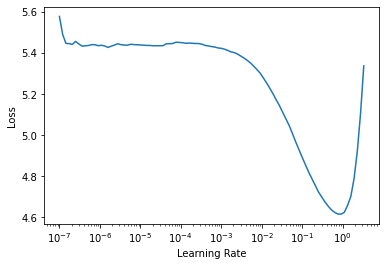

In [67]:
learn.lr_find()

In [68]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.328511,3.701925,0.385212,40.525223,00:09


In [69]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.491231,3.426033,0.409961,30.754398,00:09
1,3.322086,3.208036,0.445180,24.730467,00:09
2,3.183404,3.102603,0.460583,22.255817,00:08
3,2.962675,3.046831,0.473497,21.048529,00:08
4,2.756520,3.077628,0.475831,21.706861,00:09
5,2.535140,3.101026,0.481539,22.220734,00:09
6,2.317158,3.186062,0.478270,24.192976,00:09
7,2.128913,3.223199,0.482372,25.108305,00:09
8,1.970878,3.266666,0.481343,26.223755,00:09
9,1.848356,3.273186,0.480382,26.395294,00:08


In [71]:
learn.save_encoder('/content/drive/MyDrive/finetuned')

In [72]:
TEXT = "Just got sent this photo"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [73]:
print("\n".join(preds))

Just got sent this photo from Hiroshima on Twitter shot to detonate by Hiroshima one night a bomb was in the head on 1 / t.co / league Through Heat Wave Gusts Through 60 Degrees
Just got sent this photo from Armageddon http : / / t.co / re - releases # Armageddon # Armageddon All my friends have been electrocuted . That 's why they have body bagging wounds . Severe


## Fine-tuning the Clasifier

In [78]:
blocks = (
    TextBlock.from_df(
        'text', 
        seq_len=dls_lm.seq_len, 
        vocab=dls_lm.vocab
        ), 
    CategoryBlock()
)

dls = DataBlock(
    blocks=blocks,
    get_x=ColReader('text'),
    get_y=ColReader('target'),
    splitter=RandomSplitter(0.2)
)

In [79]:
dls_clas = dls.dataloaders(train, bs=128)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [82]:
dls_clas.show_batch(max_n=3)

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos xxup info xxup r. xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup wnd : xxunk / 5 . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup xxunk . xxup tmp : 10 . xxup xxunk : xxunk .,0
2,xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0


In [83]:
len(dls_clas.train_ds), len(dls_clas.valid_ds)

(6091, 1522)

In [84]:
learn = text_classifier_learner(
    dls_clas, 
    AWD_LSTM, 
    metrics=[accuracy, FBeta(beta=1)]
    ).to_fp16()
    
learn.load_encoder('/content/drive/MyDrive/finetuned')

In [85]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.560995,0.467114,0.789093,0.730025,00:08


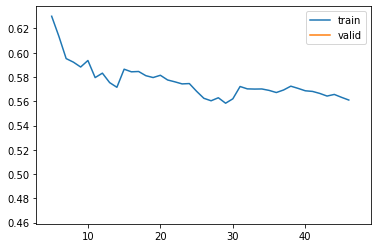

In [86]:
learn.recorder.plot_loss()

In [87]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.519139,0.465475,0.791721,0.740377,00:08


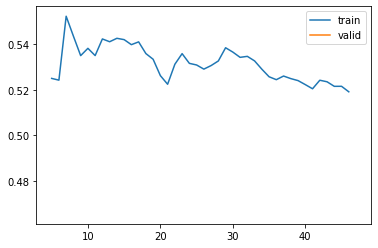

In [88]:
learn.recorder.plot_loss()

In [89]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.480539,0.445430,0.802234,0.733864,00:08


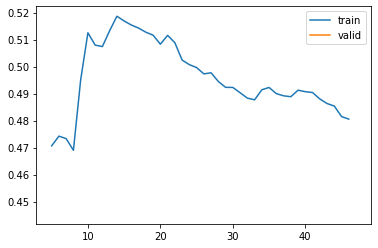

In [90]:
learn.recorder.plot_loss()

In [91]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.435117,0.450855,0.810775,0.764321,00:08
1,0.415164,0.450384,0.812746,0.765818,00:08


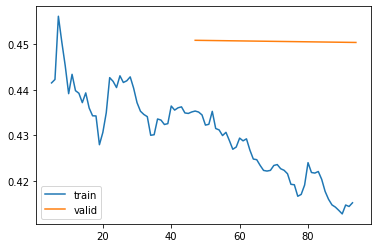

In [92]:
learn.recorder.plot_loss()

In [93]:
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.404141,0.455527,0.817346,0.774351,00:08
1,0.399917,0.455834,0.813403,0.770227,00:08
2,0.391006,0.468439,0.815374,0.769104,00:08
3,0.369477,0.483077,0.814717,0.767327,00:08
4,0.346296,0.503988,0.800920,0.762725,00:08
5,0.325532,0.533112,0.795007,0.755486,00:08
6,0.302740,0.542047,0.798949,0.760938,00:08
7,0.291484,0.534377,0.795664,0.757221,00:08
8,0.272865,0.540717,0.800263,0.760252,00:08
9,0.267551,0.544910,0.787779,0.750579,00:08


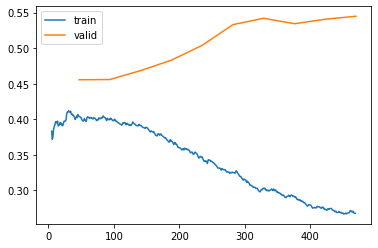

In [94]:
learn.recorder.plot_loss()

In [117]:
# Rebuild interpreter and replot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)

In [125]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       886
           1       0.74      0.76      0.75       636

    accuracy                           0.79      1522
   macro avg       0.78      0.78      0.78      1522
weighted avg       0.79      0.79      0.79      1522



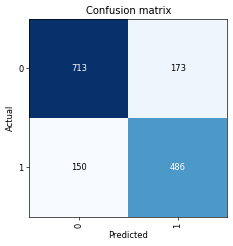

In [120]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

#other


## text preprocessing

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

train_df["text"] = train_df["text"].apply(remove_URL)
test_df["text"] = test_df["text"].apply(remove_URL)

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

train_df["text"] = train_df["text"].apply(remove_html)
test_df["text"] = test_df["text"].apply(remove_html)

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df["text"] = train_df["text"].apply(remove_emoji)
test_df["text"] = test_df["text"].apply(remove_emoji)

## word embeddings

## xgboost